In [17]:
# system libraries
import os
import warnings
import cv2
import seaborn as sns
  
# ignoring all the warnings
warnings.simplefilter('ignore')
  
# import data handling libraries
import numpy as np
import pandas as pd
  
# importing data visualisation libraires
import matplotlib.pyplot as plt 
%matplotlib inline
  
# import image processing library
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split

In [18]:
import os
base_path = os.path.join(os.getcwd(), "..")

train_csv_path = f"{base_path}/data/raw/CheXpert-v1.0-small/train.csv"
test_csv_path = f"{base_path}/data/raw/CheXpert-v1.0-small/valid.csv"
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Take a Quick Look at the Data Structure

In [19]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   No Finding                  22381 non-null   float64
 6   Enlarged Cardiomediastinum  44839 non-null   float64
 7   Cardiomegaly                46203 non-null   float64
 8   Lung Opacity                117778 non-null  float64
 9   Lung Lesion                 11944 non-null   float64
 10  Edema                       85956 non-null   float64
 11  Consolidation               70622 non-null   float64
 12  Pneumonia                   27608 non-null   float64
 13  Atelectasis   

### check non-numeric clumn values

In [21]:
for (column, t) in zip(train_df.columns, train_df.dtypes):
    if column != 'Path' and t == object:
        print(column)
        a = train_df[column].unique()
        print(a)

Sex
['Female' 'Male' 'Unknown']
Frontal/Lateral
['Frontal' 'Lateral']
AP/PA
['AP' nan 'PA' 'LL' 'RL']


In [22]:
for fl in ['Frontal', 'Lateral']:
    print(fl)
    print(train_df[train_df['Frontal/Lateral']==fl]['AP/PA'].unique())

Frontal
['AP' 'PA' 'LL' 'RL']
Lateral
[nan]


In [23]:
def encode_categorial_features(df):
    df['Frontal/Lateral'] = df['Frontal/Lateral'].map({'Frontal': 1, 'Lateral': 0})
    df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0, 'Unknown': np.nan})
    df['AP/PA'] = df['AP/PA'].map({'AP': 1, 'PA': 2, 'LL': 3,  'RL':4})
    return df

In [24]:
train_df = encode_categorial_features(train_df)
test_df = encode_categorial_features(test_df)

In [25]:
train_df.describe()

,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223413.000000,223414.000000,223414.000000,191027.000000,22381.0,44839.000000,46203.000000,117778.000000,11944.000000,85956.000000,70622.000000,27608.000000,68443.000000,78934.000000,133211.000000,6492.000000,12194.000000,123217.000000
mean,0.593681,60.430653,0.855036,1.154193,1.0,-0.035795,0.409346,0.848911,0.644508,0.456769,-0.183498,-0.461134,-0.005304,0.206540,0.559706,0.134011,0.688699,0.932680
std,0.491147,17.820925,0.352065,0.361410,0.0,0.718442,0.769323,0.472571,0.691607,0.741785,0.753980,0.828249,0.990244,0.493529,0.648859,0.966183,0.565435,0.283377
min,0.000000,0.000000,0.000000,1.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,49.000000,1.000000,1.000000,1.0,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
50%,1.000000,62.000000,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,74.000000,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,90.000000,1.000000,4.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

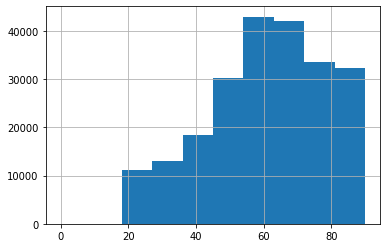

In [26]:
train_df['Age'].hist()

## Looking for Corelations

In [27]:
obs_columns = train_df.columns[5::]
obs_columns

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [28]:
corr = train_df.corr()
# drop No Finding because it only has 1 calsses
corr = corr.drop("No Finding", axis=0).drop("No Finding", axis=1)


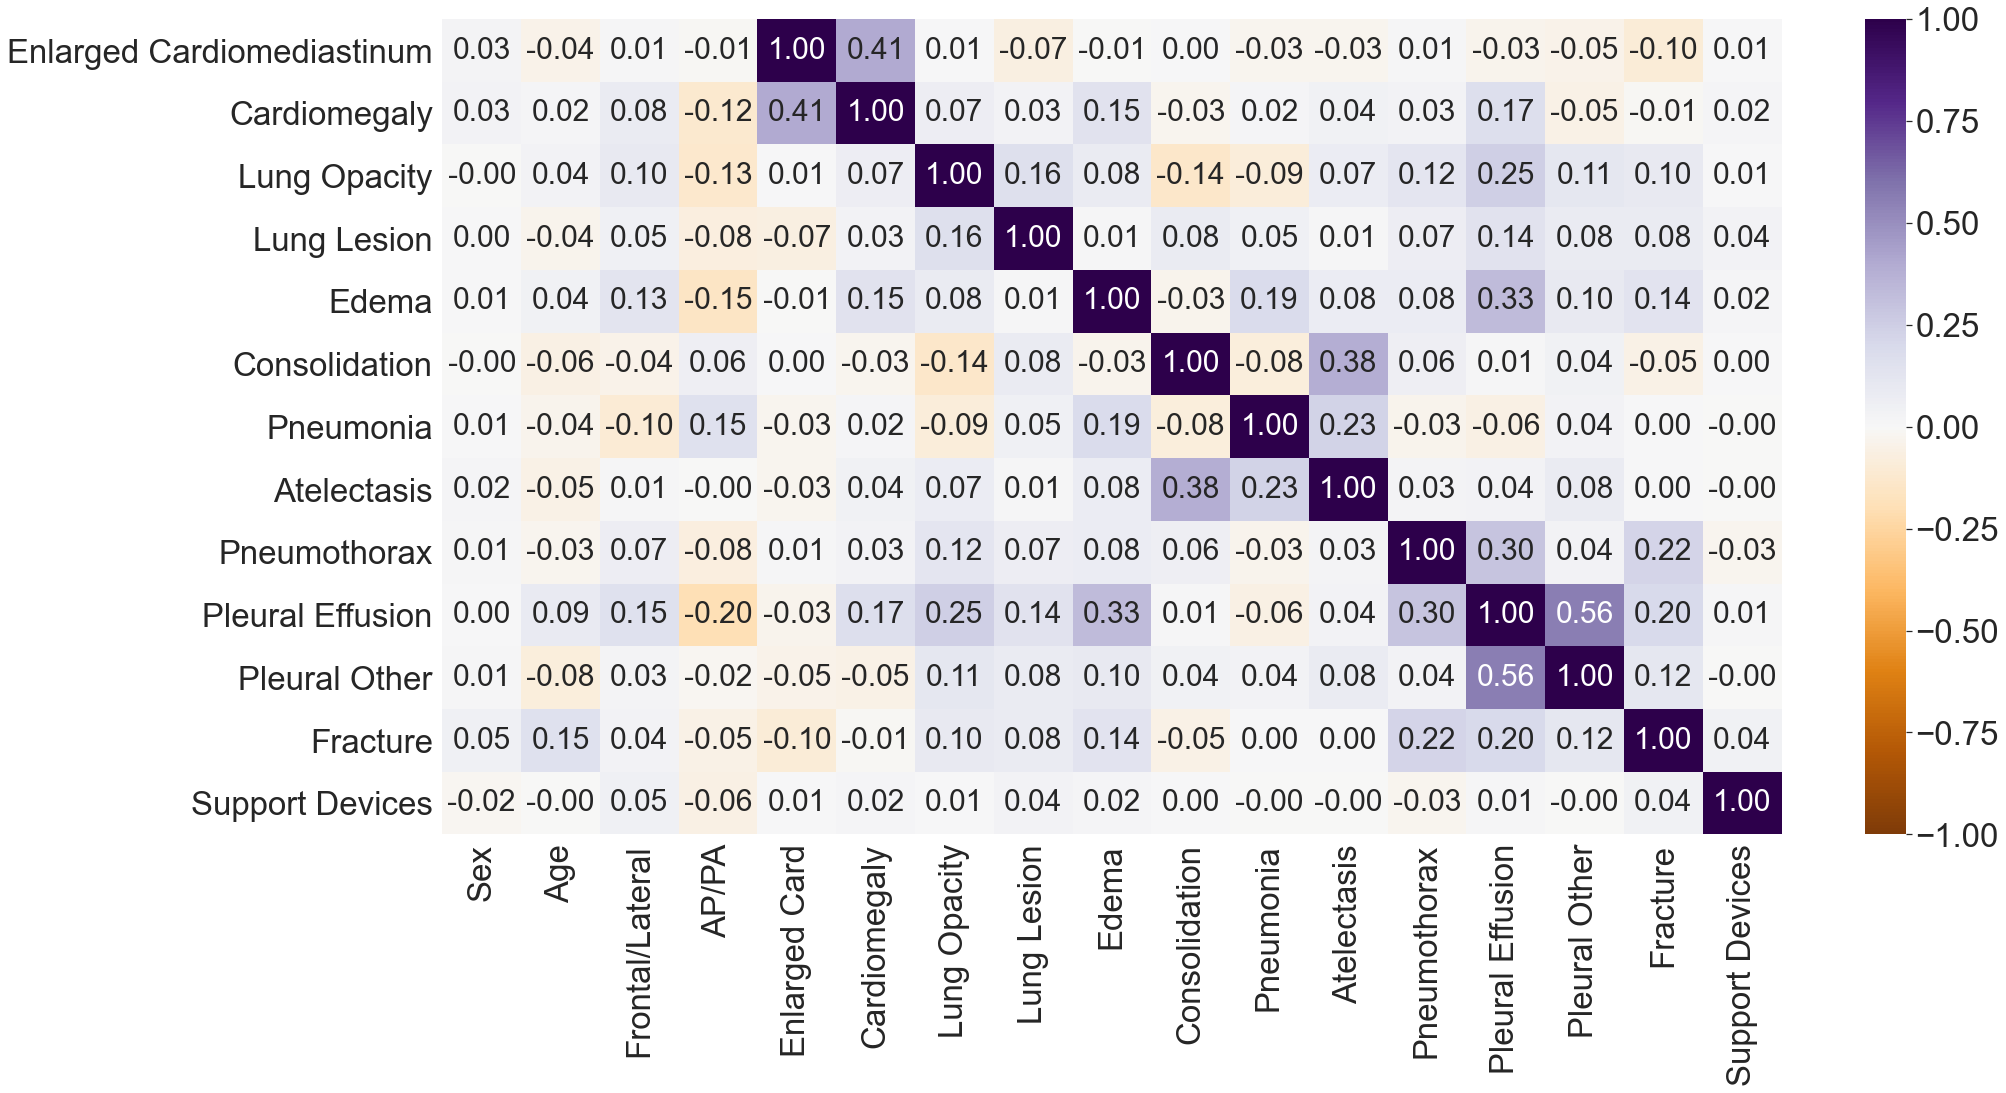

In [29]:
fig = plt.figure(figsize=(30, 15))
sns.set(font_scale=3)
xticklabels = [
    'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Enlarged Card', 'Cardiomegaly',
    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
    'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
    'Fracture', 'Support Devices'
]
ax = sns.heatmap(corr.iloc[4:, :],
                 xticklabels=xticklabels,
                 vmin=-1,
                 vmax=1,
                 cmap='PuOr',
                 annot=True,
                 fmt=".2f",
                 annot_kws={"fontsize": "small"})

## Classes weight

In [30]:
obs_df = train_df[obs_columns]
value_count_df = obs_df.apply(lambda c: c.value_counts()).T
value_count_df

,-1.0,0.0,1.0
No Finding,NaN,NaN,22381.0
Enlarged Cardiomediastinum,12403.0,21638.0,10798.0
Cardiomegaly,8087.0,11116.0,27000.0
Lung Opacity,5598.0,6599.0,105581.0
Lung Lesion,1488.0,1270.0,9186.0
Edema,12984.0,20726.0,52246.0
Consolidation,27742.0,28097.0,14783.0
Pneumonia,18770.0,2799.0,6039.0
Atelectasis,33739.0,1328.0,33376.0
Pneumothorax,3145.0,56341.0,19448.0


In [31]:
weight_df = value_count_df[1.0] / (value_count_df[1.0] + value_count_df[0])
weight_df.apply(lambda x: round(x, 2)).to_frame()

,0
No Finding,NaN
Enlarged Cardiomediastinum,0.33
Cardiomegaly,0.71
Lung Opacity,0.94
Lung Lesion,0.88
Edema,0.72
Consolidation,0.34
Pneumonia,0.68
Atelectasis,0.96
Pneumothorax,0.26


In [32]:
def calculate_classes_distribution(df, sort=True):
    df_size = len(df)
    classes = [('Positive(%)', 1.0), ("Uncertain(%)", -1.0), ('Negative(%)', 0)]
    result = {}

    for o in obs_columns:
        result[o] = {}
        for n, v in classes:
            count = df[df[o]==v][o].count()
            result[o][n] = (count, round(count/df_size * 100, 2))

    result_df = pd.DataFrame(result)
    if sort:
        result_df = result_df.sort_values(by='Positive(%)', axis=1, ascending=False).applymap(lambda v: f"{v[0]}({v[1]})")
    return result_df.T



In [33]:
print(len(train_df))
calculate_classes_distribution(train_df, sort=True)

223414


,Positive(%),Uncertain(%),Negative(%)
Support Devices,116001(51.92),1079(0.48),6137(2.75)
Lung Opacity,105581(47.26),5598(2.51),6599(2.95)
Pleural Effusion,86187(38.58),11628(5.2),35396(15.84)
Edema,52246(23.39),12984(5.81),20726(9.28)
Atelectasis,33376(14.94),33739(15.1),1328(0.59)
Cardiomegaly,27000(12.09),8087(3.62),11116(4.98)
No Finding,22381(10.02),0(0.0),0(0.0)
Pneumothorax,19448(8.7),3145(1.41),56341(25.22)
Consolidation,14783(6.62),27742(12.42),28097(12.58)
Enlarged Cardiomediastinum,10798(4.83),12403(5.55),21638(9.69)


In [34]:
print(len(test_df))
calculate_classes_distribution(test_df, sort=True)

234


,Positive(%),Uncertain(%),Negative(%)
Lung Opacity,126(53.85),0(0.0),108(46.15)
Enlarged Cardiomediastinum,109(46.58),0(0.0),125(53.42)
Support Devices,107(45.73),0(0.0),127(54.27)
Atelectasis,80(34.19),0(0.0),154(65.81)
Cardiomegaly,68(29.06),0(0.0),166(70.94)
Pleural Effusion,67(28.63),0(0.0),167(71.37)
Edema,45(19.23),0(0.0),189(80.77)
No Finding,38(16.24),0(0.0),196(83.76)
Consolidation,33(14.1),0(0.0),201(85.9)
Pneumonia,8(3.42),0(0.0),226(96.58)


We should select the following 5 pathology for evaluation:

* Atelectasis	
* Cardiomegaly	
* Consolidation	
* Edema	
* Pleural Effusion